# Восстановление золота из руды

## Подготовка данных

__Цель проекта:__ - Подготовить модель машинного обучения для предскаазания коэффициента восстановления золота из золотосодержащей руды. Доступны данные с параметрами добычи и очистки. Модель необходима для оптимизации производства.

Задачи: Подготовить данные;
Провести исследовательский анализ данных;
Построить и обучить модель.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv('C:/Users/user/Downloads/gold_recovery_train_new.csv')
data_test = pd.read_csv('C:/Users/user/Downloads/gold_recovery_test_new.csv')
data_full = pd.read_csv('C:/Users/user/Downloads/gold_recovery_full_new.csv')

In [3]:
data_test.info()
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [4]:
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())
print(data_full.duplicated().sum())

0
0
0


Дубликатов нет, зато есть пропуски. Маштабы признаков сильно отличаются друг от друга. 

Проверим, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery.

In [5]:
t = data_train['rougher.output.tail_au']
f = data_train['rougher.input.feed_au']
c = data_train['rougher.output.concentrate_au']
calc_recovery = c * (f - t) / (f * (c - t)) * 100
right_recovery = data_train['rougher.output.recovery']

Найдем MAE между расчётами и значением признака.

In [6]:
print('Абсолютная средняя ошибка -',mean_absolute_error(right_recovery,calc_recovery))

Абсолютная средняя ошибка - 9.73512347450521e-15


Значение MAE близко к нулю. Значит, рассчитанное нами значение recovery верно.

Проанализируем признаки, недоступные в тестовой выборке.

In [7]:
for col in list(data_train.columns):
    if col not in list(data_test.columns):
        print(col)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В тестовой выборке отсутсвуют output каждого этапа техпроцесса. Для построения новой модели нам нужны офлайн-метрики, так что пропуски в тестовой выборке ни на что не влияют. (Может быть кроме calculation данных)

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Нам нужно выбрать признаки для обучения модели. Для этого уберем признаки, которых нет в тестовой выборке и уберем признаки, которые слабо коррелируют с целевыми признаками.
Рассмотрим корреляцию целевых признаков final.output.recovery, rougher.output.recovery. с остальными. 

In [9]:
test_columns = list(data_test.columns)
test_and_target = ['final.output.recovery', 'rougher.output.recovery'] + test_columns

In [10]:
#data_train[test_and_target].corr().sort_values(by='final.output.recovery',ascending = False)

In [11]:
#data_train[test_and_target].corr().sort_values(by='rougher.output.recovery',ascending = False)

Скорее всего, необходимо выбрать признаки для final.output.recovery', 'rougher.output.recovery' отдельно. Так как это будет две модели.

Пока оставим в train только признаки, которые есть в test и разделим датасет на final и rougher. Заодно удалим столбец data и пропуски.

In [12]:
data_train_new = data_train[test_and_target].dropna()

train_final = data_train_new.loc[:,data_train_new.columns.str.contains("cleaner|final")]
train_rougher = data_train_new.loc[:,data_train_new.columns.str.contains("rougher")]

train_final_target = train_final['final.output.recovery']
train_final_features = train_final.drop(['final.output.recovery'],axis=1)

train_rougher_target = train_rougher['rougher.output.recovery']
train_rougher_features = train_rougher.drop(['rougher.output.recovery'],axis=1)

test_final = data_test.loc[:,data_test.columns.str.contains("cleaner|final")].dropna()
test_rougher = data_test.loc[:,data_test.columns.str.contains("rougher")].dropna()

Вывод: данные загружены, показатель эффективности обогащения рассчитан корректно. Дубликатов нет, пропуски удалил (что-то можно было восстановить, но их не так много). Трейн дата была поделена на две (final и rougher), а также удалены избыточные признаки. Маштабируем данные на этапе проверки модели.

## Анализ данных

Рассмотрим концентрацию металлов на различных этапах очистки.

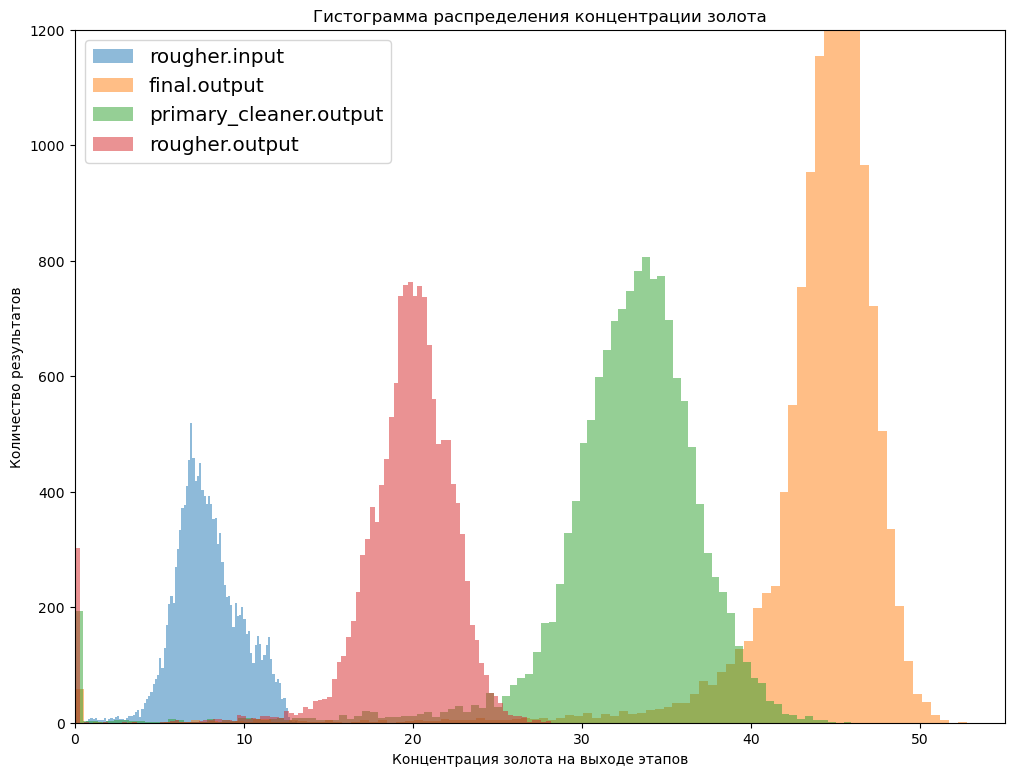

In [13]:
plt.figure(figsize=[12,9])

plt.hist(data_train['rougher.input.feed_au'], bins=100, label = 'rougher.input', alpha=.5)
plt.hist(data_train['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5)
plt.hist(data_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(data_train['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5)
plt.xlim([0, 55])
plt.ylim([0, 1200])
plt.xlabel("Концентрация золота на выходе этапов")
plt.ylabel("Количество результатов")
plt.legend(loc='upper left', fontsize='x-large')
plt.title("Гистограмма распределения концентрации золота")
plt.show()

Концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота.

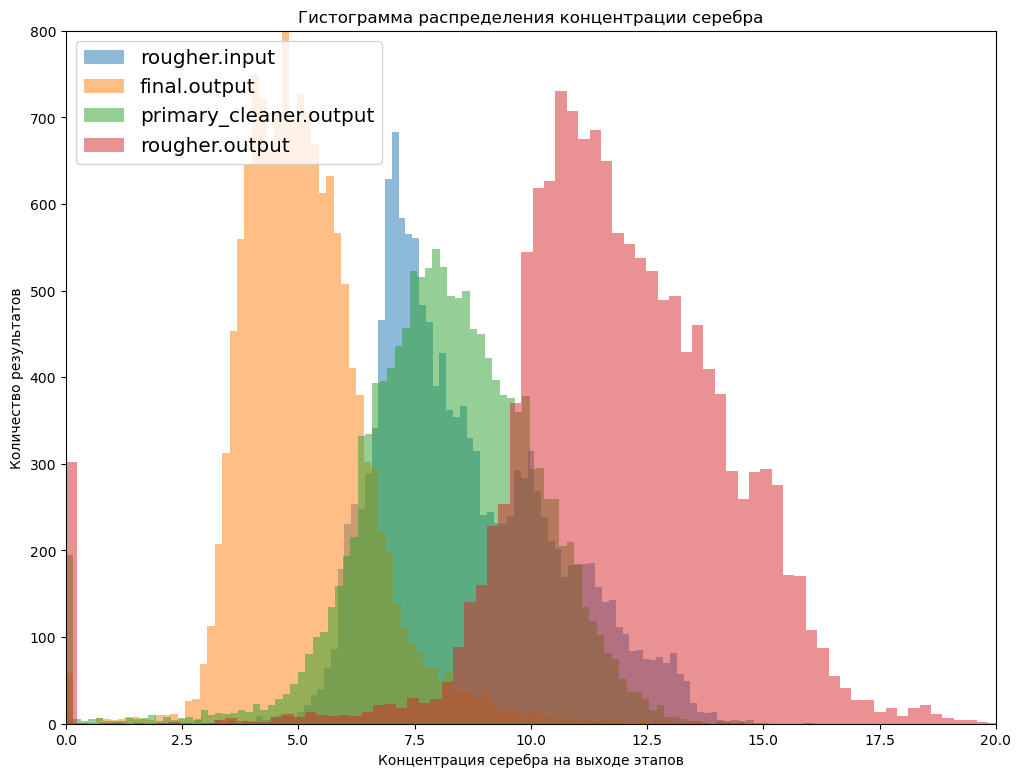

In [14]:
plt.figure(figsize=[12,9])

plt.hist(data_train['rougher.input.feed_ag'], bins=100, label = 'rougher.input', alpha=.5)
plt.hist(data_train['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5)
plt.hist(data_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(data_train['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 20])
plt.ylim([0, 800])

plt.xlabel("Концентрация серебра на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show()

Концентрация серебра уменьшается с каждым этапом.

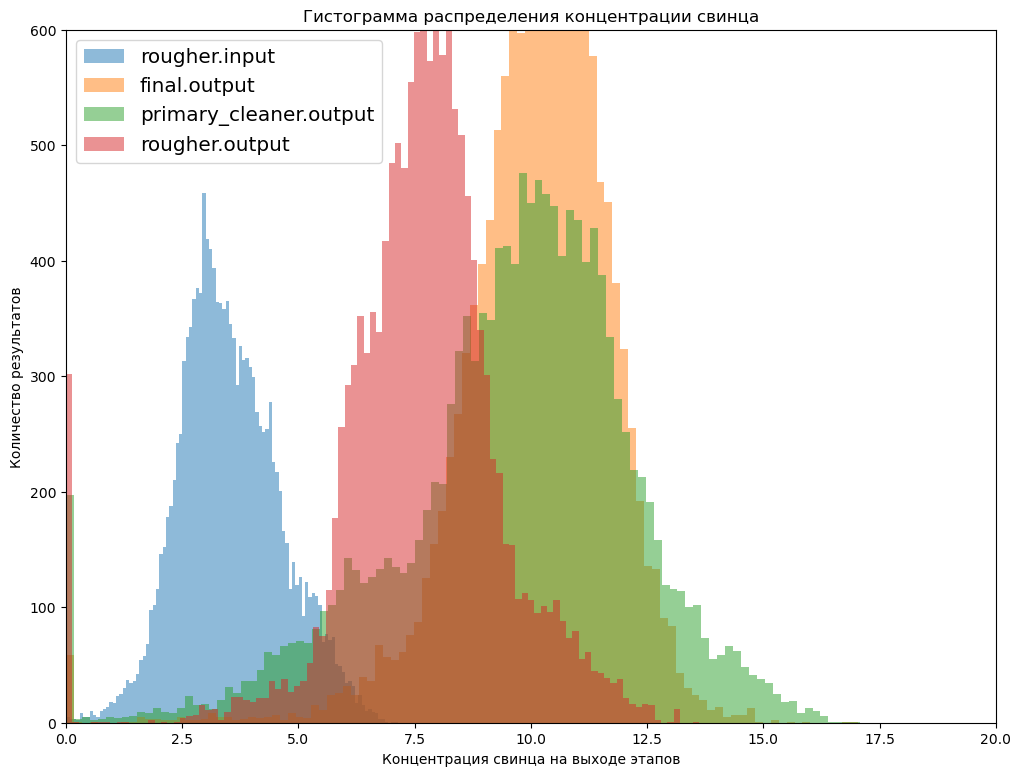

In [15]:
plt.figure(figsize=[12,9])

plt.hist(data_train['rougher.input.feed_pb'], bins=100, label = 'rougher.input', alpha=.5)
plt.hist(data_train['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5)
plt.hist(data_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(data_train['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 20])
plt.ylim([0, 600])

plt.xlabel("Концентрация свинца на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show()

Концентрация свинца повышается до этапа первичной очистки. 

Изучим размеры сырья на разных этапах.

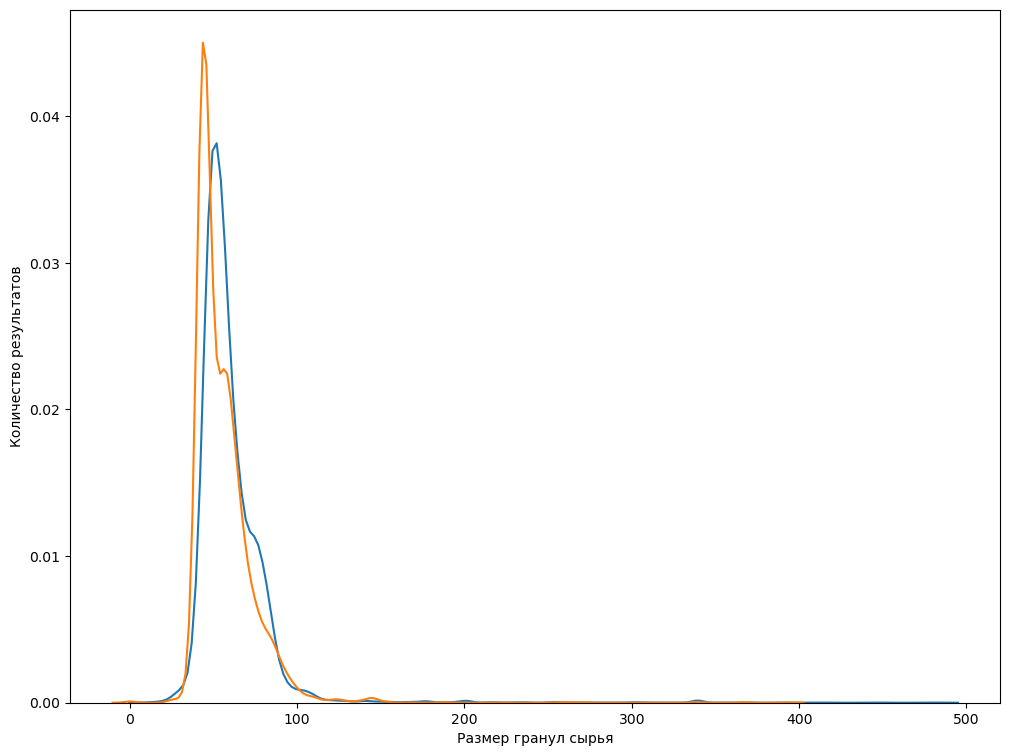

In [16]:
plt.figure(figsize=[12,9])
plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")
sns.kdeplot(data_train['rougher.input.feed_size'])
sns.kdeplot(data_test['rougher.input.feed_size'])
plt.show()

Распередление размера гранул до флотации в обоих выборках практически идентичны.

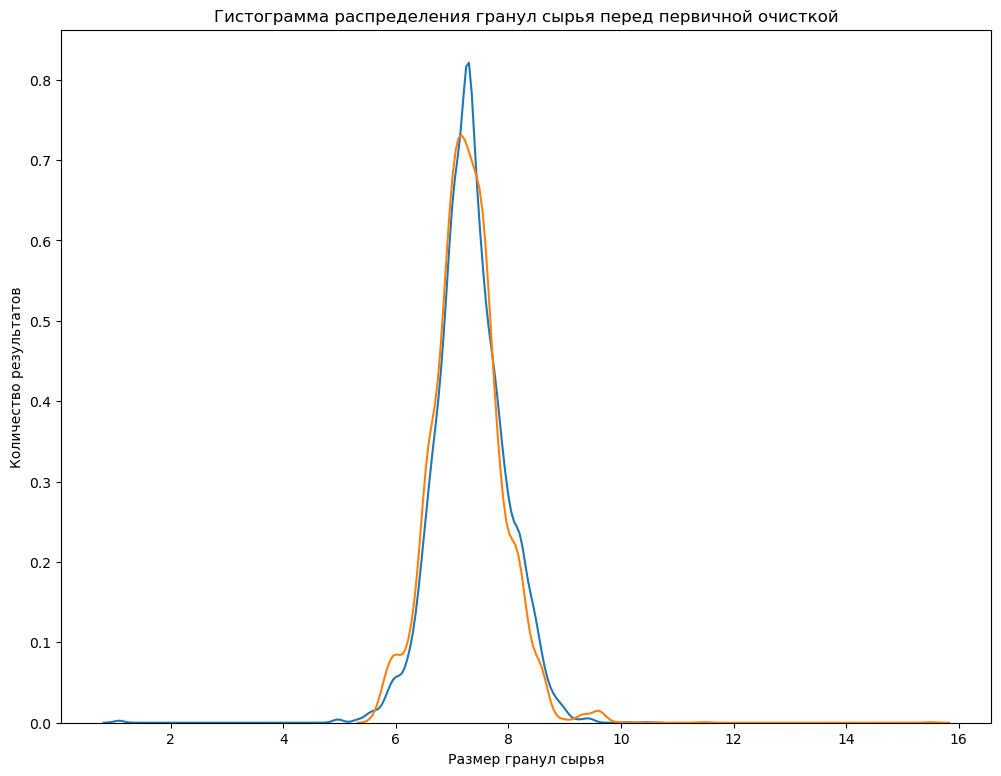

In [17]:
plt.figure(figsize=[12,9])
plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")
sns.kdeplot(data_train['primary_cleaner.input.feed_size'])
sns.kdeplot(data_test['primary_cleaner.input.feed_size'])
plt.title("Гистограмма распределения гранул сырья перед первичной очисткой")
plt.show()

Распределения очень похожи.
Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [18]:
final_output_sum = (data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] + 
                    data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_sol'])
primary_cleaner_output__sum = (data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] + 
                               data_train['primary_cleaner.output.concentrate_pb'] + data_train['primary_cleaner.output.concentrate_sol'])
rougher_output_sum = (data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] + 
                      data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_sol'])
rougher_input_feed = (data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] + 
                      data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_sol'])

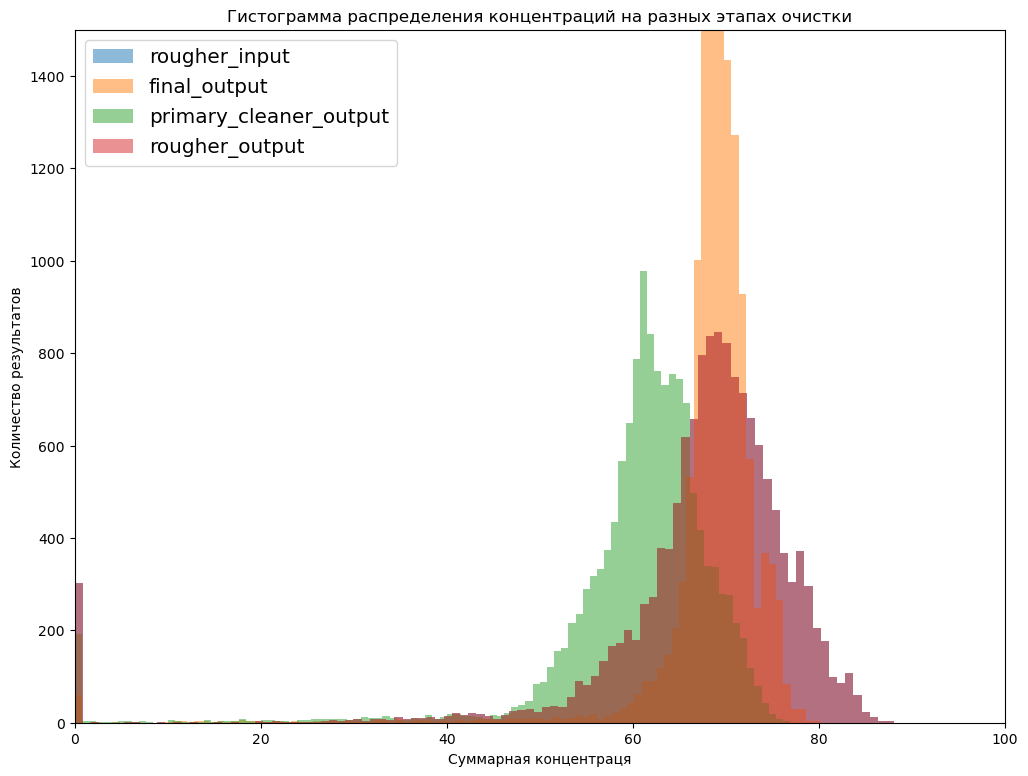

In [19]:
plt.figure(figsize=[12,9])

plt.hist(rougher_input_feed, bins=100, label = 'rougher_input', alpha=.5)
plt.hist(final_output_sum, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output__sum, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_sum, bins=100, label = 'rougher_output', alpha=.5)
rougher_input_feed
plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

Распределения идентичны.Есть много выбросов в районе 0 (их ещё было видно на отдельных графиках золота и тд..) 

Избавимся от аномальных значений в обучающей выборке.

In [20]:
data_train['final_output_sum'] = final_output_sum
data_train['primary_cleaner_output__sum'] = primary_cleaner_output__sum
data_train['rougher_output_sum'] = rougher_output_sum
data_train['rougher_input_feed'] = rougher_input_feed
data_train_2 = data_train.loc[(data_train['final_output_sum'] > 40) & (data_train['primary_cleaner_output__sum'] > 40) &
                              (data_train['rougher_output_sum'] > 40) & (data_train['rougher_input_feed'] > 40)]  

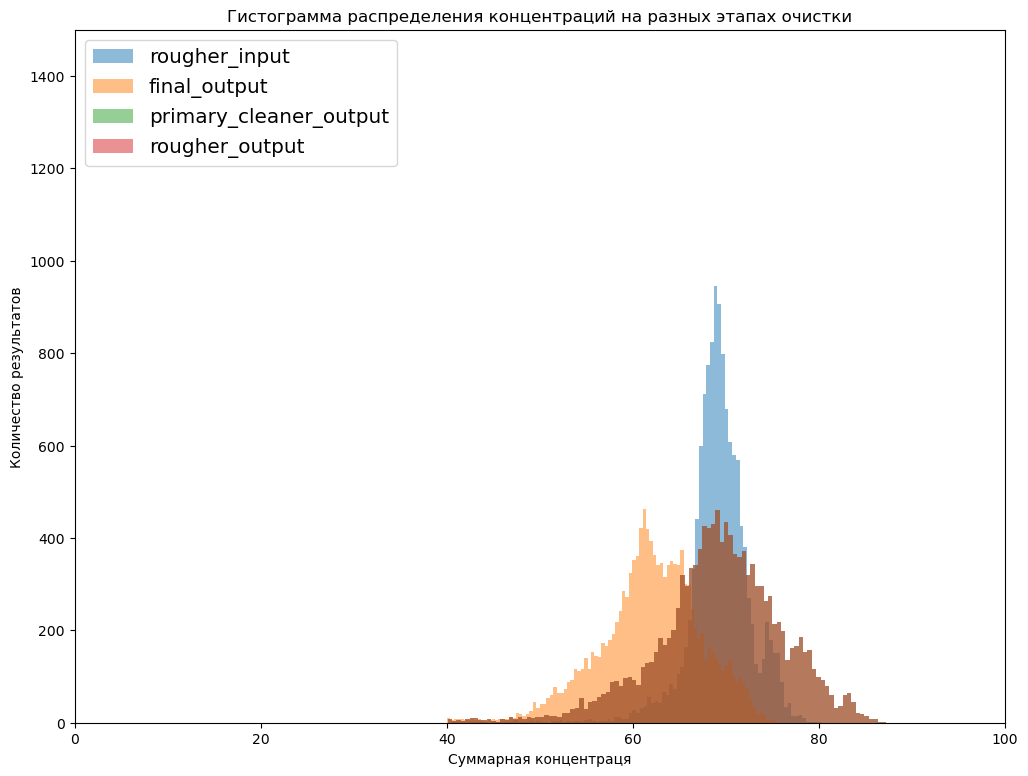

In [21]:
plt.figure(figsize=[12,9])

plt.hist(data_train_2['final_output_sum'], bins=100, label = 'rougher_input', alpha=.5)
plt.hist(data_train_2['primary_cleaner_output__sum'], bins=100, label = 'final_output', alpha=.5)
plt.hist(data_train_2['rougher_output_sum'], bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(data_train_2['rougher_input_feed'], bins=100, label = 'rougher_output', alpha=.5)
rougher_input_feed
plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

Избавились от аномальных значений. Но теперь надо обновить выборки, созданные на первом этапе.

In [22]:
data_train_new = data_train_2[test_and_target].dropna()

train_final = data_train_new.loc[:,data_train_new.columns.str.contains("cleaner|final")]
train_rougher = data_train_new.loc[:,data_train_new.columns.str.contains("rougher")]

train_final_target = train_final['final.output.recovery']
train_final_features = train_final.drop(['final.output.recovery'],axis=1)

train_rougher_target = train_rougher['rougher.output.recovery']
train_rougher_features = train_rougher.drop(['rougher.output.recovery'],axis=1)

test_final = data_test.loc[:,data_test.columns.str.contains("cleaner|final")].dropna()
test_rougher = data_test.loc[:,data_test.columns.str.contains("rougher")].dropna()

Вывод: Проанализированы концентрации металлов (Au, Ag, Pb) на всех стадиях очистки для обучающей выборки. Выявлены и удалены аномальные значения. Распределение гранул сырья на двух выборках не отличаются.

## Модель

Напишем функцию для вычесления smape.

In [23]:
def smape(true,predict):
    return 1 / len(true) * sum( abs(true - predict) / ( (abs(true) + abs(predict) ) / 2) ) * 100

def final_smape(smape_r,smape_f):
    return 0.25 * smape_r + 0.75 * smape_f

Обучим и оценим качества моделей.

In [24]:
model = LinearRegression()

smape_final = -1 * cross_val_score(model, train_final_features, train_final_target, 
                             scoring = make_scorer(smape,greater_is_better=False),
                             cv = 5,
                             n_jobs = -1).mean()

smape_rougher = -1 * cross_val_score(model, train_rougher_features, train_rougher_target, 
                             scoring =  make_scorer(smape,greater_is_better=False),
                             cv = 5,
                             n_jobs = -1).mean()
print('Линейная регрессия:')
print('sMAPE rougher: {:.2f} %'.format(smape_rougher))
print('sMAPE cleaner: {:.2f} %'.format(smape_final))
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_rougher, smape_final)))

Линейная регрессия:
sMAPE rougher: 6.24 %
sMAPE cleaner: 8.77 %
Final sMAPE: 8.14 %


In [25]:
model = DecisionTreeRegressor()
max_depth = [x for x in range(2, 4, 2)]
hyperparams = {'max_depth':max_depth, 'random_state':[12345],"min_samples_leaf":[1,2,3,4]}

gscv = GridSearchCV(model,hyperparams,scoring= make_scorer(smape,greater_is_better=False),cv=5)
gscv.fit(train_final_features,train_final_target)
print(gscv.best_params_)
smape_final_2 = gscv.best_score_ * -1
print(smape_final_2)

gscv = GridSearchCV(model,hyperparams,scoring= make_scorer(smape,greater_is_better=False),cv=5)
gscv.fit(train_rougher_features,train_rougher_target)
print(gscv.best_params_)
smape_rougher_2 = gscv.best_score_ * -1
print('DecisionTreeRegressor:')
print('sMAPE rougher: {:.2f} %'.format(smape_rougher_2))
print('sMAPE cleaner: {:.2f} %'.format(smape_final_2))
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_rougher_2, smape_final_2)))

{'max_depth': 2, 'min_samples_leaf': 1, 'random_state': 12345}
8.97148128833375
{'max_depth': 2, 'min_samples_leaf': 1, 'random_state': 12345}
DecisionTreeRegressor:
sMAPE rougher: 7.00 %
sMAPE cleaner: 8.97 %
Final sMAPE: 8.48 %


Наилучшая результат показала модель линейной регресси. Проверим её на тестовой выборке.

Возьмем тестовые значения target из data_full.

In [26]:
data_test_new = data_test.merge(data_full[['rougher.output.recovery', 'final.output.recovery', 'date']],
                         how = 'inner', on= 'date')
final_test_target = data_test_new.loc[test_final.index,'final.output.recovery']
rougher_test_target = data_test_new.loc[test_rougher.index,'rougher.output.recovery']

In [27]:
model = LinearRegression()
model.fit(train_rougher_features, train_rougher_target)
rougher_recovery_predicted = model.predict(test_rougher)

model.fit(train_final_features, train_final_target)
final_recovery_predicted = model.predict(test_final)

f_smape = smape(final_test_target,final_recovery_predicted)
r_smape = smape(rougher_test_target,rougher_recovery_predicted)
LR_smape = final_smape(r_smape,f_smape)
print(LR_smape)

9.136700708576486


Сравним полученную модель с константной.

In [28]:
mean_r = np.array([train_rougher['rougher.output.recovery'].mean() for _ in range(len(rougher_test_target))])
mean_f = np.array([train_final['final.output.recovery'].mean() for _ in range(len(final_test_target))])

In [29]:
dummy_f_smape = smape(final_test_target,mean_f)
dummy_r_smape = smape(rougher_test_target,mean_r)
dummy_smape = final_smape(dummy_f_smape,dummy_r_smape)
print(dummy_smape)

9.05958321812658


Вывод: функция была написана, модель построена и обучена. Smape константной модели такой же как и у линейной регресси. 


__Итоговый вывод:__ данные подготовлены (отобраны признаки, избыточные и нерелевантные для модели), анализ данных проведен, построенна и обучены модель с помощью техники кросс-валидации. Smape у константной модели точно такой же.=/

Для дальнейшего улучшения качества моделирования можно пересмотреть:
- оценку аномалий, пропусков, соотвествие законом химии и физики
- создание новых признаков для моделей, Features Engineering
- отбор самих моделей ML и гиперпараметров
- параметры производственного процесса